<a href="https://colab.research.google.com/github/z1qsx/qtcreat/blob/master/Algorithmic_Data_Science_Assignments_Yekailiang1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Overview
For this assessment you are asked to submit a Jupyter notebook that reports on what you have learnt about the complexity of different algorithms for finding the similarities of documents using a bag-of-words representation.

Scenario

Imagine, you have a collection of d (d > 10) documents each containing at least w (w > 50) English words. For testing purposes, you may wish to construct or collect such a collection. A document can be represented as a bag-of-words, i.e., as the set of the words it contains together with associated frequencies. This is naturally stored using a Python dictionary. This can be converted to a dense vector (e.g., a numpy array) where there is a dimension for each of the V words in the English vocabulary.

During lab sessions you will have been expected to have implemented various algorithms that will enable you to address each of the following five questions:

### Introduction

This part contains a selection of two different similarity algorithms. Some question and analysis are about running time of Jaccard'similarity and the cosine similarity. Therefore, the report explores what is different algorithms for Jaccard' similarity and cosine similarity and running time respectively.
Estimating the constant for two similarities.

This report in question 1, I will examine and analyse what is the theoretical worst-case running time of Jaccard's similarity measure applied to documents represented as bags of words.

In question 2, I also examine and analyse what is the theoretical worst-case running time of the cosine similarity measure applied to documents represented as dense vectors to estimate the constant. After examined, I need to compare using the implementation of the dot product in numpy with my own implementation.

After, examine two similarities, I need to examine and analyse that cosine similarity directly computes documents from sparse(dictionary) representations without converting them into dense(vector) representations. Moreover, its result will compare the previous implementation of the two similarities in question 3.
Question 4 is which computes all-pairs similarities for a collection of documents. Furthermore, I examine what is the theoretical worst-case running time for computing all-pairs similarities and give an estimate of how long it would take to compute all-pairs similarities for 200K documents for both measures.

Finally, for question 5,I need to  use the map-reduce computing paradigm to implement a parallel version of all-pairs similarities for documents and test them for accuracyits and average running time for 50 documents. 

In [0]:
#import module
from nltk.tokenize import word_tokenize
from nltk.corpus import brown
from timeit import default_timer as timer
import nltk
from nltk.corpus import semcor
from nltk.corpus import inaugural
from nltk.corpus import stopwords
import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import time

import operator
from multiprocessing import Pool
from collections import defaultdict

In [58]:
nltk.download('brown')
nltk.download('semcor')
nltk.download('inaugural')
nltk.download('stopwords')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package semcor to /root/nltk_data...
[nltk_data]   Package semcor is already up-to-date!
[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

*collecting d> 10 documents *

In [0]:
#collecting 50 documents
allfiles=semcor.fileids() #list of fileids
len(allfiles)
secor_doc=[]
for temp in range(50):
    secor_doc.append(semcor.words(allfiles[temp]))
                                 

*Calculate average running time*

In [0]:
def timeit(somefunc,*args,repeats=10,**kwargs):
    times=[]
    while repeats>0:
        starttime=time.time()
        ans=somefunc(*args,**kwargs)
        endtime=time.time()
        timetaken=endtime-starttime
        times.append(timetaken)
        repeats-=1
    
    mean=np.mean(times)
 
    return mean

In [0]:
def token_frequency(tokens):
    freqs = {}
    for token in tokens:
        try :
            freqs[token] += 1
        except KeyError:
            
            freqs[token] = 1
    return freqs

In [0]:
def normalise(tokenlist):
    tokenlist=[token.lower() for token in tokenlist]
    tokenlist=["NUM" if token.isdigit() else token for token in tokenlist]
    tokenlist=["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in tokenlist]
    tokenlist=["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in tokenlist]
    return tokenlist

def filter_stopwords(tokenlist):
    stop = stopwords.words('english')
    return [w for w in tokenlist if w.isalpha() and w not in stop]

def make_bow(somestring):
    rep=normalise(somestring)   
    rep=filter_stopwords(rep)  
    dict_rep={}
    for token in rep:
        dict_rep[token]=dict_rep.get(token,0)+1  #step 5
    return(dict_rep)

In [0]:
my_doc=[]
for doc_m in secor_doc:
    my_doc.append(make_bow(doc_m))

In [0]:
def draw_chart(num_mx,time_my,names):
    logxs=[np.log10(x) for x in num_mx]
    logys=[np.log10(y) for y in time_my]
    
    plt.subplots_adjust(1,0,2.5,0.5)
    plt.subplot(121)
    plt.plot(num_mx,time_my)
    plt.xlabel("Length of List")
    plt.ylabel("Average time")
    plt.title("Worst Case Running Time of "+ names)
    #plt.ylim(-6,-3)
    
    plt.subplot(122)
    plt.scatter(logxs,logys)
    plt.xlabel("Length of List")
    plt.ylabel("Average time")
    plt.title("Worst Case Running Time of "+ names)
    plt.show()
    
    return logxs,logys
def cal_slope(logxs, logys):
    slope, intercept, r_value, p_value, std_err = stats.linregress(logxs, logys)
    print("Slope is {} and intercept is {}".format(slope,intercept))
    

1.What is the theoretical worst case running time of Jaccard’s similarity measure applied to documents represented as bags of words? Show that this is the case empirically. Estimate the constant for your implementation and computer.

## The Jaccard' s similarity formula
$J(A,B)=\cfrac{\mid A\cap B\mid}{\mid A \cup B\mid}$

In [0]:
def jac_sim(A, B):
    U = A.keys() | B.keys()
    I = A.keys() & B.keys()
    jac =  len(I) / len(U)
    return jac    

### The theoretical worst case running time analysis:
Jaccard's similarity measure is the ratio of the cardinality (size) of the intersection of two sets to the cardinality of the union of two sets. If elements of two sets are the same, their similarity is 1. However, if elements of two sets are totally different, their similarity is 0. The Jaccard' similarity contains three steps. The first step is union of two sets. Its worst case running time is $O(len(doc1.keys)+len(doc2.keys))$. Secondly, the measure need to calculate intersection of two sets. So, its worst case running time is $O(len(document1.keys)*len(document2.keys))$. The final step is that results of union is divided by resluts of intersection. Therefore, according to the above analysis, the Jaccard' similarity worst running depend on document size, if the document size is n, the jaccard's similarity measure worst running is similar O(n) by the big O notation.

In [0]:
timexs=[]
sima_x=[]
doc_num=[]
cal_ti=0
for i in range(20):
    timess = []
    for ca_num in range(10):
        start = timer()
        sim_A_B = jac_sim(my_doc[0],my_doc[i])
        end = timer()
        cal_ti+=(end - start)
    timek=(cal_ti/10)
    sima_x.append(str(round(sim_A_B,4)))
    timexs.append(round(end - start,7))
    doc_num.append(len(my_doc[0])+len(my_doc[i]))
    temp_s=round((len(my_doc[0]) - len(my_doc[i])*sim_A_B))
    print(round(timek,7),round(sim_A_B,4),len(my_doc[0])+len(my_doc[i]),temp_s)

0.0001103 1.0 1294 0
0.0004999 0.1438 1344 547
0.0008841 0.0749 1335 595
0.0010867 0.0918 1237 593
0.0012137 0.0747 1324 596
0.0013391 0.0965 1363 578
0.0014627 0.0919 1283 589
0.001592 0.0762 1441 587
0.0017131 0.0839 1395 584
0.0018874 0.0711 1476 588
0.0020163 0.07 1436 592
0.0021536 0.0732 1423 590
0.0022672 0.0766 1251 601
0.0023789 0.0704 1246 605
0.0024981 0.096 1290 585
0.0026005 0.0731 1130 612
0.0027242 0.0716 1243 604
0.0028581 0.0806 1301 594
0.0029879 0.0665 1412 596
0.0030975 0.0889 1188 599


In [0]:
store=[]
store.append(timexs)

store.append(sima_x)

store.append(doc_num)

df=pd.DataFrame(store, index=['Running time','similarity','number of words'])
df=df.T
df.sort_values('similarity')

,Running time,similarity,number of words
18,9.05e-05,0.0665,1412
10,0.0001331,0.07,1436
13,0.0001138,0.0704,1246
9,0.0001627,0.0711,1476
16,0.0001064,0.0716,1243
15,0.0001206,0.0731,1130
11,9.33e-05,0.0732,1423
4,8.48e-05,0.0747,1324
2,8.48e-05,0.0749,1335
7,0.0001326,0.0762,1441


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

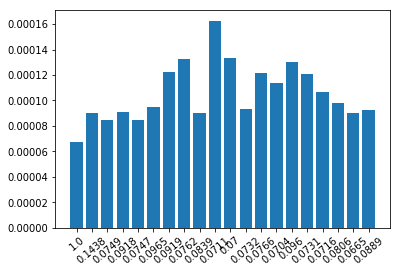

In [0]:
plt.bar(sima_x,timexs)
plt.xticks(rotation=40)

From above chart, it show that relationship of Jaccard's similarity and running time. When the words of documents is approximately 650, their running time do not depend on the similarity. However, its running time was increase when its number of documents was growth. It will be estimated.

Jaccard's similiarity (chart 1.1)

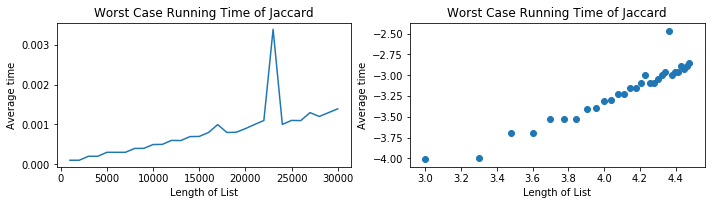

Slope is 0.8910904900957792 and intercept is -6.849231802531387


In [0]:
times = []
number=[]
for n in range(1000, 300 * 100 + 1, 1000):
    
    A = token_frequency(brown.words()[:n])
    B = token_frequency(brown.words()[n:2*n])
    
#     start = timer()
#     sim_A_B = jac_sim(A,B)
#     end = timer()
    
    run_time=timeit(jac_sim,A,B)
#     print(n)
    number.append(n)
    times.append(run_time)

lx,ly=draw_chart(number,times,'Jaccard')
cal_slope(lx,ly)

### Estimate the constant for my implementation and computer.
Now I investigate the worst-case running time of this algorithm for different lengths of documents.
From the above charts, the first chart is when the number of doucments words was a rise from 1000 to 30000, its running time had a significant growth. However, it difficult to observe its worst running time trend. So, if it is about linear $O(n^1)$, I need some Maths.
If $y=c_a.x^n$ then it follows that: $\log(y) = \log(c_a) + n \log(x)$
therefore, if I plot a graph of $\log(y)$ against $\log(x)$ the gradient will be n and the y intercept will be $\log(c_a)$. According to the second chart of worst- case running time of Jaccard's similarity measure. Its gradient and intercept were approximately 0.891 and -6.849 respectively. It means Jaccard's similarity  measure that this is fairly straight and the gradient is approximately 0.89 to 1. The y intercept is about -7 so $𝑐𝑎≈10^{−6.8}\approx 0.0000001$. Based on this analysis, I estimate the worst running time $y\approx c_a.x^1 \longrightarrow$ $O(n)$ This illustrates that empirically we have$ 𝑂(𝑛^{0.89})$ which is slightly better than $𝑂(𝑛)$. Because in the algorithm, there are some instructions which are only carried out O(n) times (outside the inner loop). This will make the power appear lower than it really is unless n is asymptotically large. Therefore, if the number of words increases, it would close the O(n)

In [0]:
#tag frequency for each words
sims = []
processed_docs=[]
for i in range(len(docs)):
    processed_docs.append(token_frequency(word_tokenize(docs[i])))

2.What is the theoretical worst case running time of the cosine similarity measure applied to documents represented as dense vectors? Show that this is the case empirically. Estimate the constant for your implementation and computer. You may wish to compare using the implementation of the dot product in numpy with your own implementation.

### The consine similarity formula  
$cos\theta = \cfrac{A\cdot B}{\sqrt{A\cdot A}\sqrt{B\cdot B}}$

In [0]:
# The function is to make the dense vectors from dictionary
def make_matrix(list_of_dicts):
    #first of all make a list of all of the features that occur in any document - these will be the dimensions of the matrix
    allfeatures={}    
    for docdict in list_of_dicts:
#         print('docdict',docdict)
        for feat in docdict.keys():
#             print('feat',feat)
            allfeatures[feat]=1
#             print('allfeatures',allfeatures)
    dimensions=list(allfeatures.keys())
#     print(dimensions)
    #don't strictly need to sort it - but it is good practise to make sure it is reproducible
    so=sorted(dimensions)
    matrix=[]
    #each row in the matrix will be one of the dimensions
    for dimension in dimensions:
        row=[]
        #look up the appropriate value for each document
        for docdict in list_of_dicts:
            row.append(docdict.get(dimension,0)) #this will append the document's value if present, 0 otherwise
        matrix.append(row)
        
        
    return matrix

## it might be useful to be able to transpose a matrix so we can compare documents
def transpose(matrix):
    transposed=[]
    for i in range(0,len(matrix[0])):
        transposed.append([row[i] for row in matrix])
        
    return transposed
#call make_matrix on whatever variable holds your list of dictionaries representation of your documents

In [0]:
#cosine similarity meansure
def L2_norm(A):
    sq_sum = 0
    for i in range(len(A)):
        sq_sum += A[i]**2
    return sq_sum**0.5


def cosine_sim(A, B):
    
    dot_prod = 0
    for i in range(len(A)):
        dot_prod += A[i] * B[i]

    L2_A = L2_norm(A)
    L2_B = L2_norm(B)
    
    return dot_prod / (L2_A * L2_B)

### The theoretical worst-case running time analysis:
Cosine similarity measure is that real-valued ‘vector’ representations of objects lead naturally to geometric notions of similarity. Before, calculation of cosine similarity, I need to compute documents represented as dense vectors. According to lab 6, I use the function make_matrix to make the matrix from a dictionary of frequency. When cosines similarity measure calculate dense vectors. it has three steps. Firstly, I apply the for loop to iterate through arrays and collection to dot product each corresponding vectors of a document. Therefore, its worst running time is O(n). Secondly, it computes the magnitude of two documents vectors and it has a for loop. Finally, results of dot product divided by results of magnitude. From these analyses, I assumed that running time of the measure is about O(n)by the big O notation. It will estimate the constant for my implementation and computer. Moreover, it would be compared using the implementation of the dot product in numpy with my own implementation.

In [0]:
times_1 = []

for n in range(1000, 300 * 100 + 1, 1000):
    
    A = token_frequency(brown.words()[:n])
    B = token_frequency(brown.words()[n:2*n])
    
    MT = np.array(transpose(make_matrix([A,B])))
    
    running_time=timeit(cosine_sim,MT[0], MT[1])
    times_1.append(running_time)


In [0]:
#dot dense vectors
def cosine_sim_dot(A, B):
    
    dot_prod = 0
    
    dot_prod =np.dot(A,B)

    L2_A = L2_norm(A)
    L2_B = L2_norm(B)
    
    return dot_prod / (L2_A * L2_B)

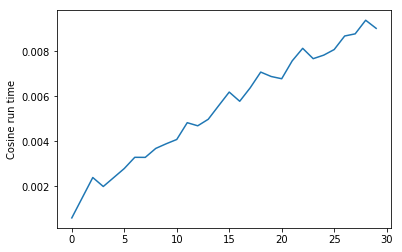

In [0]:
times_2 = []

for n in range(1000, 300 * 100 + 1, 1000):
    
    A = token_frequency(brown.words()[:n])
    B = token_frequency(brown.words()[n:2*n])

    MT = np.array(transpose(make_matrix([A,B])))
    
    running_time=timeit(cosine_sim_dot,MT[0], MT[1])
    times_2.append(running_time)

    
plt.plot(times_2)
plt.ylabel('Cosine run time')
plt.show()

Cosine similarity with vector iteration(chart 2.1 and chart 2.2)

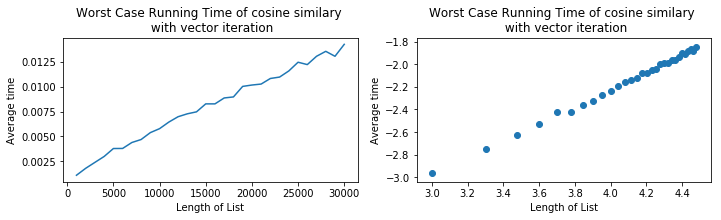

Slope is 0.7554522128887582 and intercept is -5.246121743384572


In [0]:
#consine of documents iteration
lx,ly=draw_chart(number,times_1,'cosine similary \n with vector iteration')
cal_slope(lx,ly)

Cosine similarity with numpy dot product(chart 2.3 and chart 2.4)

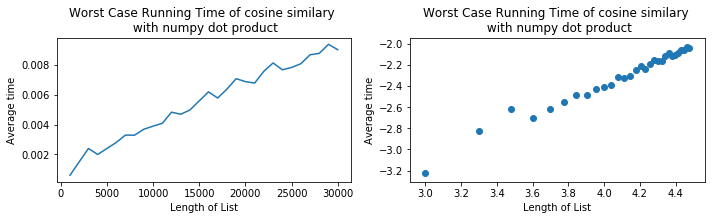

Slope is 0.7331657588181568 and intercept is -5.317878609469529


In [0]:
#consine of numpy dot product
lx,ly=draw_chart(number,times_2,'cosine similary \n with numpy dot product')
cal_slope(lx,ly)

### Comparing two measures(chart 2.5)

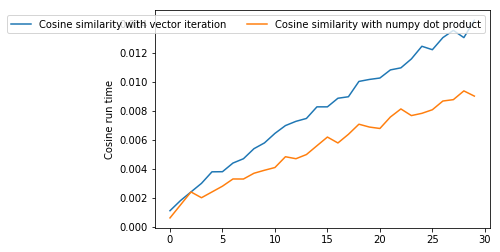

In [0]:
plt.plot(times_1)
plt.plot(times_2)
plt.title("Comparing two measures")

label = ["Cosine similarity with vector iteration","Cosine similarity with numpy dot product"]
plt.legend(label, loc = 0, ncol = 2)
plt.ylabel('Cosine run time')
plt.show()

### Estimate the constant for my implementation and computer.
#### (NB: Cosine similarity measure with vector iteration means we apply for loop documents iteration to compute documents represented as dense vectors. Cosine similarity measure with numpy dot product means that it apply numpy dot product)

The worst-case running time of this cosine similarly measure was investigated for different lengths of documents words between 1000 and 30000. Firstly, from the above charts of cosine similarity measure with vector iteration(chart 2.1 and chart 2.2), the first chart is when the number of documents words was an increase from 1000 to 30000, its running time was a significant growth. Moreover, the first chart of cosine similarity measure with numpy dot product had the same variation tendency. These results showed that cosine similarity with vector iteration and cosine similarity measure with numpy dot product had the same variation tendency. It observed that its worst running time trend similar linear $𝑂(𝑛^1)$.   

Secondly, I also used some above maths. If $𝑦=𝑐𝑎.𝑥^𝑛$ then it follows that: log(𝑦)=log(𝑐𝑎)+𝑛log(𝑥). Therefore, according to the second charts of a worst-case running time of  cosine similarity with vector iteration and consine similarity measure with numpy dot product (chart 2.2 and  chart 2.4).  Gradient t of cosine similarity with vector iteration and cosine similarity measure with numpy dot product were approximately 0.755 and 0.733 respectively. Their intercept were approximately -5.2 and -5.3 respectively. It means the gradient and intercept of two cosine similarity measure were significantly similar. Moreover, this is fairly straight and the gradient is approximately 0.7 to 1. The y intercept is about -5 so $𝑐𝑎≈10^{−5}=0.00001$. 

Depend on the above analysis, I can estimate constant that the worst running times of first cosine similarity measure and second cosine similarity measure are $y=10^{-5}*x^{0.755}$ and $y=10^{-5}*x^{0.733}$. This illustrates that empirically we have$𝑂(𝑛^{0.755})$for original measure and $𝑂(𝑛^{0.733})$ for numpy which are slightly greater than 𝑂(𝑛). The same reason is that measures there are some instructions which are only carried out O(n) times (outside the inner loop). This will make the power appear lower than it really is unless n is asymptotically large. Finally, for the chart of comparing two functions(chart 2.5), two curves have a similar trend，However, the curve of cosine similarity measure with numpy dot product lower than the curve of cosine similarity measure with vector iteration. This means if we use the numpy dot, the running time would be reduced. According to the previous analysis, if, we apply numpy dot product, its time complexity is $𝑂(𝑛^{0.733}) $. However, the cosine similarity with vector iteration is $𝑂(𝑛^{0.755}). Therefore, if we apply cosine similarity with numpy dot product , it would more effective.

3.Write a function which computes cosine similarity directly from sparse (dictionary) representations without converting them into dense (vector) representations? Make sure you test your function empirically for correctness and for efficiency and compare it to your previous implementatIon of the cosine similarity and your implementation of Jaccard’s measure.

In [0]:
#cosine similarity directly from sparse (dictionary) representation
A = token_frequency(brown.words()[0:100])
B= token_frequency(brown.words()[100:200])

Sparse (dictionary) representations

In [0]:
print(A,'\n',B)

{'The': 1, 'Fulton': 1, 'County': 1, 'Grand': 1, 'Jury': 1, 'said': 1, 'Friday': 1, 'an': 1, 'investigation': 1, 'of': 1} 
 {"Atlanta's": 1, 'recent': 1, 'primary': 1, 'election': 1, 'produced': 1, '``': 1, 'no': 1, 'evidence': 1, "''": 1, 'that': 1}


In [0]:
from math import sqrt
def dot(d1,d2):
    if len(d1) < len(d2):
        a = d1
        b = d2
    else:
        a = d2
        b = d1
    dotproduct = 0
    for word,count in a.items():
        dotproduct += count * b.get(word,0)
    return dotproduct

def cos_sim_nlp(d1,d2):
    numerator = dot(d1,d2)
    denominator = sqrt(dot(d1,d1)*dot(d2,d2))
    return numerator/denominator

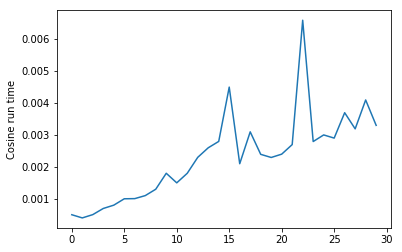

In [0]:
def cos_dense_nl():
#     times_cose1 = []
    times_cose2 = []
    numberxs=[]
    for n in range(1000, 300 * 100 + 1, 1000):
    
        A = token_frequency(brown.words()[:n])
        B = token_frequency(brown.words()[n:2*n])
    
        numberxs.append(n)
        
        running_time=timeit(cos_sim_nlp,A, B)
        times_cose2.append(running_time)
   

    plt.plot(times_cose2)
    plt.ylabel('Cosine run time')
    plt.show()
        
    return times_cose2,numberxs
cos_den=cos_dense_nl()

Cosine similarity directly from sparse (dictionary) representations(chart 3.1 and 3.2)

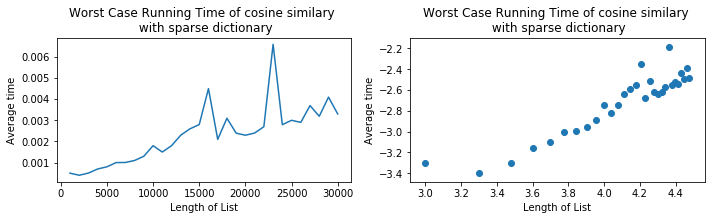

Slope is 0.765139708177342 and intercept is -5.8486494815613215


In [0]:
lcx,lcy=draw_chart(cos_den[1],cos_den[0],'cosine similary \n with sparse dictionary')
cal_slope(lcx,lcy)

### Estimate the constant for my implementation and computer.
According to question 3, before to compute running time, I need to write a function which computes cosine similarity directly from sparse (dictionary) representations without converting them into dense (vector) representations. It means that it compute cosine similarity by keys and frequency of dictionary. From the above two charts of the worst-case running time of cosine similary measure as dictionary reoresentation, the first chart illustrates that the running time was an increase with the increase in the number of words. Its curve also similar linear growth. So that, I use the same math method to analyse the linear relationship of this algorithm. According to the second chart of worst case running time of cosine similary measure as dictionary. Its gradient t was approximately 0.765. Its intercept was approximately -5.84. Moreover, this is fairly straight and the gradient is approximately 0.765 to 1. The y intercept is about $-6$ so $𝑐𝑎≈10^{−5.8}=0.000001$. Likewise, I can estimate the worst running time $𝑦=𝑐𝑎.𝑥^{0.765}$ This illustrates that empirically we have$𝑂(𝑛^{0.765})$ which is slightly greater than 𝑂(𝑛). The same reason is that some instructions of the algorithm are executed only O (n) times (outside the inner loop). This will make the power appear to be lower than the actual value, unless n is asymptotically large.

Compare four measures(chart 3.3)

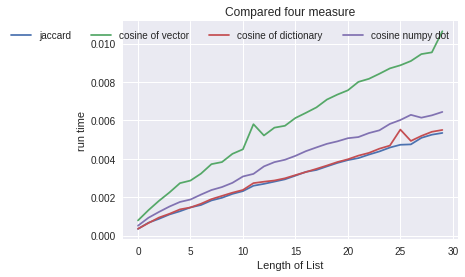

In [68]:
def cos_dense_nl():
    times_cose1 = []
    times_cose2 = []
    times_jac=[]
    times_cos_dot=[]
    for n in range(1000, 300 * 100 + 1, 1000):
    
        A = token_frequency(brown.words()[:n])
        B = token_frequency(brown.words()[n:2*n])
    
    
        MT = np.array(transpose(make_matrix([A,B])))
        
       
        #cosine's similarly of vectors
        
        running_time1=timeit(cosine_sim,MT[0], MT[1])
        times_cose1.append(running_time1)
        

        #cosine's similarly of dictionary
        
        running_time2=timeit(cos_sim_nlp,A, B)
        times_cose2.append(running_time2)
        
         # jaccard's similarly

        
        running_time3=timeit(cos_sim_nlp,A, B)
        times_jac.append(running_time3)
        
        #cosine's similarly of numpy dot
        running_time4=timeit(cosine_sim_dot,MT[0], MT[1])
        times_cos_dot.append(running_time4)
        
    plt.plot(times_jac)   
    plt.plot(times_cose1)
    plt.plot(times_cose2)
    plt.plot(times_cos_dot)
    
    plt.xlabel("Length of List")
    plt.title("Compared four measure")
    label = ["jaccard", "cosine of vector","cosine of dictionary","cosine numpy dot"]
    plt.legend(label, loc = 0, ncol = 4)
    plt.ylabel('run time')
    plt.show()
        
    return times_cose2
cos_den=cos_dense_nl()

From the above charts( chart 3.3). it indicates that four algorithms have a similar increase trend. However, the curve of the cosine of vector is significantly higher than the others. This means the running time is greater than others. Moreover, the curve of the cosine of numpy dot product is lower than the curve of vector and higher than the curve of Jaccard and cosine of the dictionary. The curve of Jaccard  and cosine of the dictionary not only had the lowest worst running time but also had a most similar trend in the chart of compare four algrothm. For analysis of chart, firstly, the cosine similarity measure applied to documents represented as dense vectors. It needs to compute where there is a dimension for each of the V words in the English vocabulary. This means it needs to compute all words frequency to make the vector, if some words do not occur in other documents, the vectors will be interpolated with zero.  Therefore, it leads to the length of the list was increased with the number of document words. Similarly, if  we apply the numpy dot product, it also computes the expended vectors. However, it is more efficient than the first measure by previous analysis. If cosine similarity measure is directly from sparse (dictionary) representations without converting them into dense (vector) representations, its bag of a list is lower than the first and second method. It not only does not expend the frequency of each word as vectors but also only compute the frequency of each word. This reduces the size of data and running time. For the Jaccard' similarity. its running time was the lowest. Because it does not iterate through arrays and collections and their running time of intersection and union only depend on the number of words in documents. This is the cause of this distribution.  Finally,  four measures depend on length of documents, if the length is an increase, their running time also rise.Different algorithms running time is significant different. Even if the algorithm is the same, different method lead to different running time.

4.Write a function which computes all-pairs similarities for a collection of documents. The function should take a list of dictionaries (the document collection) and a parameter specifying the similarity measure to be used. What is the theoretical worst-case running time for computing all-pairs similarities? Does it matter what the similarity measure is? Can you give an estimate of how long it would take to compute all-pairs similarities for 200K documents for both measures? (Note: that whilst you should test your function for all-pairs similarities (with d > 10), you do not need to prove the theoretical worst case empirically or test with 200K documents!)

In [0]:
len(brown.words())

1161192

In [0]:
def all_pair(func,flag):
    sims= []
    time_collection=[]
    number_collection=[]
    k_num=0
    j_num=0

    most_similar = (0,0,0)
    
    if flag==1:
        for i in range(len(my_doc)-1):
            for j in range(i+1, len(my_doc)):
                start = timer()
                sim_i_j = func(my_doc[i], my_doc[j])
                end = timer()
                k_num=k_num+(end-start)
                time_collection.append(k_num)
                j_num+=1
                number_collection.append(j_num)
    else: 
        for numk in range(48):
            my_docs=my_doc[0:numk+1]
            start = timer()
            k_num=0
            for i in range(len(my_docs)-1):
                for j in range(i+1, len(my_docs)):
                    sim_i_j = func(my_doc[i], my_doc[j])
            end = timer()
            k_num=(end-start)
            time_collection.append(k_num)
            number_collection.append(len(my_docs))       
            
#     plt.plot(number_collection,time_collection)
#     plt.ylabel('run time')
#     plt.show()
    return number_collection,time_collection

### Charts of Jaccard's all-pairs similarity (chart 4.1 and chart 4.2)

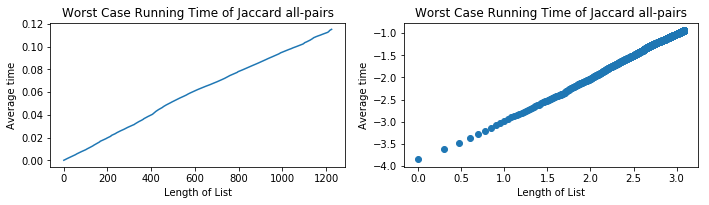

Slope is 0.9911309621556481 and intercept is -3.985751662733678


In [0]:
#only compuating Jaccard's similary 
xj,yj=all_pair(jac_sim,1)
lx,ly=draw_chart(xj,yj,'Jaccard all-pairs')
cal_slope(lx,ly)

Cosider documents iteration(chart 4.3 and chart 4.4)

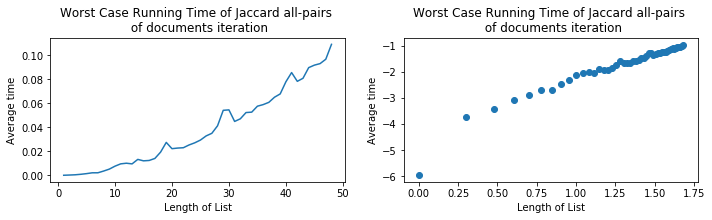

Slope is 2.2563101396445706 and intercept is -4.650829511828043


In [0]:
xj,yj=all_pair(jac_sim,0)
lx,ly=draw_chart(xj,yj,'Jaccard all-pairs \n of documents iteration')
cal_slope(lx,ly)

From above four chars of all- pairs Jaccard's similarity measure, the first and second charts did not consider the document iteration(chart 4.1 and chart 4.2). They show that if the funcion only compuate runing time of a collection of 49 documents each containing at least 600 English words.The worst running time of Jaccard' similarity measure also was similar O(n). According to the second chart, its slope and intercept were 0.991 and -3.98 respectively.  Based on previous maths. If $y=c_a.x^n$ then it follows that: $\log(y) = \log(c_a) + n \log(x)$ This is fairly straight and the gradient is approximately 0.991 to 1. The y intercept is about $−3$ 𝑠𝑜 $𝑐𝑎≈10^{−3}=0.001$. Likewise, I also estimate the worst running time $𝑦=𝑐𝑎.𝑥^{0.991}$ This illustrates that empirically we have $𝑂(𝑛^{0.991})$ which is slightly greater than 𝑂(𝑛). The reason is same previous analysis that the algorithm there are some instructions which are only carried out O(n) times (outside the inner loop).
According to the results $y=10^{-3}x^{0.991}$, I can give an estimate of 200k documents that it is $y=10^{-3}(200000)^{0.991} \approx 200 $. However, according to the third chart and fourth chart, if we consider two for loop for documents iteration(chart 4.3 and chart 4.4), its slope and intercept were 3.18 and -4.96 respectively. This illustrates that empirically we have $𝑂(𝑛^{2.25})$ which is slightly better than $𝑂(𝑛^{3})$ . Because in the algorithm, there are some instructions which are only carried out  instructions out the inner loop. This will make the power appear lower than it really.If length of document is increase. it would close the $O(n^3)$. Its Therefore, number of documents was increase with growth of running time. Its running time is that y is $10^{-4}*x^{2.25} \approx 0.0001*(200000)^{2.25} $.Its worst running time is that $10^{-4}*x^{3} $

### Graphs of  Consine all-pair similarity (chart 4.5 and chart 4.6)

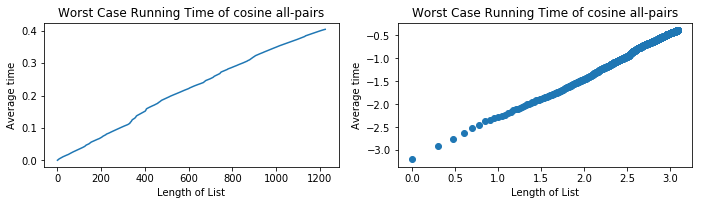

Slope is 0.9567871513715874 and intercept is -3.3273323302705573


In [0]:
xc,yc=all_pair(cos_sim_nlp,1)
lx,ly=draw_chart(xc,yc,'cosine all-pairs')
cal_slope(lx,ly)

Cosider documents iteration(chart 4.7 and chart 4.8)

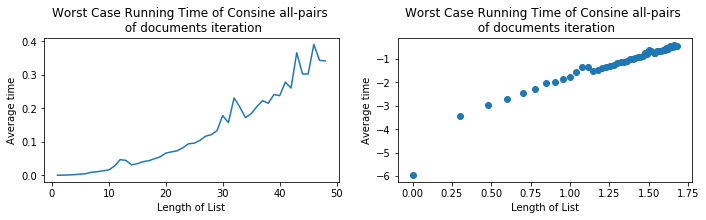

Slope is 2.454480750184999 and intercept is -4.416865388520684


In [0]:
xc,yc=all_pair(cos_sim_nlp,0)
lx,ly=draw_chart(xc,yc,'Consine all-pairs \n of documents iteration')
cal_slope(lx,ly)

The parameter is a collection of 49 documents each containing at least 600 English words. According to above graphs, the first graph and second graph illustrate that when I only compuate the consine similarity measure without documents itration(chart 4.5 and chart 4.6). Its slope and intercept were 0.956 and -3.327. So that, Based on previous maths,the gradient is approximately 0.956 to 1. The y intercept is about $−3$ 𝑠𝑜 $𝑐𝑎≈10^{−3}\approx 0.001$.I estimate the worst running time $𝑦=𝑐𝑎.𝑥^𝑛⟶𝑂(𝑛^{0.956})$ This illustrates that empirically we have $𝑂(𝑛^{0.956})$ which is slightly greater than 𝑂(𝑛). The reason is same previous analysis that the algorithm there are some instructions which are only carried out O(n) times (outside the inner loop). From above analysis, if the number of documents are 200k, I have an estimate that $y=10^{-3}*200000 \approx 200 $. Similarly，when we consider documents itration, its slope and intercept were 2.45 and -4.416. Therefore,it have $O(n^{2.45})$ and $Ca \approx -4.416$. I estimate that its y is $10^{-4.416}*(200000)^{2.45}$. Moreover, if the documnets have a increase, its worst running time is estimated about $10^{-4.416}*(200000)^{3}$ by previous analysis. 

Summary,  the theoretical worst-case running time for computing all-pairs similarities is close $O(n^3)$, However, two measure only were about $O(n^{2.25})$ and $O(n^{2.45})$. Their results were better $O(n^3)$. The reason has analysed in the above analysis. We apply which similarity measure is important. According to the above analysis, The Jaccard's similarity running time was significantly lower than the cosine similarity measure. The Jaccard's similarity running time over 1. However, the cosine similarity running time was over 0.4 when they test to compute 50 documents all-pairs. Therefore, the number of documents is important factors to affect running time. From the previous analysis, even if their process speed was similar in length of the bag, they were different in the number of documents. Moreover, their worst running time estimate were $10^{-4.65}*(200000)^{2.25}  $ and $10^{-4.416}*(200000)^{2.45}$ .




5.Use the map-reduce computing paradigm to implement a parallel version of all-pairs similarities for documents. Make sure you test your function empirically for correctness and for efficiency. Investigate the number of map processes and reduce processes which give optimal results for your implementation and computer.

In [0]:
def all_pair(func):
    sims= []
    for i in range(len(my_doc)-1):
        sims.append([])
        for j in range(i+1, len(my_doc)):
            sims[i].append([i,j])
    return sims

In [0]:
# my mapper function
def wc_mapper_parallelxx(document):
     output=[]
    
     for num in document:
        output.append((str(num[0]),num))
        
#         print(num)
#         print(str(document[0][0]))

     return output

In [0]:
#my Jaccard'similarity reducer function
def wc_reducer_parallelxx_jac(item):
    output=[]
    (word,counts)=item
    for couns in counts:
#       print(word,couns)
      
      A=my_doc[couns[0]]
      B=my_doc[couns[1]]
      U = A.keys() | B.keys()
      I = A.keys() & B.keys()
      jac =  len(I) / len(U)
      
      output.append(((couns[0],couns[1]),jac))
    return output

In [0]:
#my cosine similarity reducer  function
def wc_reducer_parallelxx_cos(item):
    output=[]
    (word,counts)=item
    for couns in counts:
#       print(word,couns)
      
      A=my_doc[couns[0]]
      B=my_doc[couns[1]]
      numerator = dot(A,B)
      denominator = sqrt(dot(A,A)*dot(B,B))
      cos_sim=numerator/denominator
      
      output.append(((couns[0],couns[1]),cos_sim))
    return output

In [0]:
def map_reduce_parallel(docm,mapper,reducer,mapprocesses=3,reduceprocesses=2):
  outputs=[]
  collector=defaultdict(list)  #this dictionary is where we will store intermediate results
                                 #it will map keys to lists of values (default value of a list is [])
                                 #in a real system, this would be stored in individual files at the map nodes
                                 #and then transferred to the reduce nodes
        
  docm1=all_pair(docm)
  mapprocesses=4
  reduceprocesses=4

  mappool = Pool(processes=mapprocesses)
  #map stage
  mapresults=mappool.map(mapper,docm1)
  mappool.close()

  collector=defaultdict(list)
  for mapresult in mapresults:
    for (key, value) in mapresult:     #pass each input to the mapper function and receive back each key,value pair yielded
      collector[key].append(value)     #append the value to the list for that key in the intermediate store


  reducepool = Pool(processes=reduceprocesses)
  #reduce stage
  reduceresults=reducepool.map(reducer,collector.items())
  reducepool.close()
  for reduceresult in reduceresults:
    outputs+=reduceresult
  return outputs

In [0]:
#test 50 documents average running time
def tests(func,ti):
  my_docs=my_doc
  k_num=0
  time_collection=[]
  start = timer()

  for tii in range(ti):
    for i in range(len(my_docs)-1):
        for j in range(i+1, len(my_docs)):
            sim_i_j = func(my_doc[i], my_doc[j])
    end = timer()
    k_num=(end-start)
    time_collection.append(k_num)
  means_time=np.mean(time_collection)
  print('(50 documents all-pair) similiarity average running time',means_time)
  return means_time

In [0]:
#test 50 documents average running time
def tests_pall(func,my_docs,mapper,reducer,ti):
  my_docs
  k_num=0
  time_collection=[]

  for tii in range(ti):
    start = timer()
    map_reduce_parallel(my_doc,mapper,reducer)
  
    end = timer()
    k_num=(end-start)
    time_collection.append(k_num)
  means_time=np.mean(time_collection)
  print('(50 documents all-pair) parallel map-reduce similiarity average running time',means_time)
  return means_time

Jaccard's similarity map-reduce implementation

Compare two Jaccard's similarity measures average running time  

In [46]:
tests_pall(map_reduce_parallel,my_doc,wc_mapper_parallelxx,wc_reducer_parallelxx_jac,10)

(50 documents all-pair) parallel Jaccard similiarity average running time 0.2999086957001055


0.2999086957001055

In [28]:
tests(jac_sim,10)

(50 documents all-pair) Jaccard similiarity average running time 0.8409540088001449


0.8409540088001449

Make sure my Jaccard's similiarity function empirically for correctness and for efficiency

Map-reduce

In [0]:
jac_sim_all=map_reduce_parallel(my_doc,wc_mapper_parallelxx,wc_reducer_parallelxx_jac)

In [34]:
print('Map-reduce compute document 0 and document 1 similarity:',jac_sim_all[0])

jac_df=pd.DataFrame(jac_sim_all,columns=['document','similiarity'])

Map-reduce compute document 0 and document 1 similarity: ((0, 1), 0.14382978723404255)


In [35]:
jac_df.head()

,document,similiarity
0,"(0, 1)",0.143830
1,"(0, 2)",0.074879
2,"(0, 3)",0.091792
3,"(0, 4)",0.074675
4,"(0, 5)",0.096541


Original Jaccard similarity measure

In [77]:
print('Jaccrad similarity document 0 and document 1 similarity:',jac_sim(my_doc[0],my_doc[1]))

Jaccrad similarity document 0 and document 1 similarity: 0.14382978723404255


In [0]:
jac_o=[]
for i in range(len(my_doc)-1):
  for j in range(i+1, len(my_doc)):
    sim_i_j = jac_sim(my_doc[i], my_doc[j])
    jac_o.append(sim_i_j)

In [42]:
#Only show first four similarity of the  all-pairs
jac_o[:5]

[0.14382978723404255,
 0.0748792270531401,
 0.09179170344218888,
 0.07467532467532467,
 0.09654062751407884]

Cosine similarity map-reduce implementation

In [78]:
tests_pall(map_reduce_parallel,my_doc,wc_mapper_parallelxx,wc_reducer_parallelxx_cos,10)

(50 documents all-pair) parallel map-reduce similiarity average running time 0.5484013150995452


0.5484013150995452

In [79]:
tests(cos_sim_nlp,10)

(50 documents all-pair) similiarity average running time 3.252834163400439


3.252834163400439

Make sure my cosine similiarity function empirically for correctness and for efficiency

Map-reduce

In [0]:
cos_sim_all=map_reduce_parallel(my_doc,wc_mapper_parallelxx,wc_reducer_parallelxx_cos)

In [53]:
print('Map-reduce cosine measure document 0 and document 1 similarity:',cos_sim_all[0])

Map-reduce cosine measure document 0 and document 1 similarity: ((0, 1), 0.4670035096857264)


In [50]:
cos_df=pd.DataFrame(cos_sim_all,columns=['document','similiarity'])
cos_df.head()

,document,similiarity
0,"(0, 1)",0.467004
1,"(0, 2)",0.371672
2,"(0, 3)",0.406700
3,"(0, 4)",0.376800
4,"(0, 5)",0.331278


Original cosine measure

In [0]:
print('document 0 and document 1 similarity:',cos_sim_nlp(my_doc[0],my_doc[1]))

document 0 and document 1 similarity: 0.4670035096857264


In [0]:
cos_o=[]
for i in range(len(my_doc)-1):
  for j in range(i+1, len(my_doc)):
    sim_i_j = jac_sim(my_doc[i], my_doc[j])
    cos_o.append(sim_i_j)

In [52]:
 cos_o[:4]

[0.14382978723404255,
 0.0748792270531401,
 0.09179170344218888,
 0.07467532467532467]

Map-reduce achieves reliability by distributing large-scale operations to each node on the network; each node periodically returns its completed work and the latest state. In question 5,  I used the map-reduce computing paradigm to implement a parallel version of all-pairs similarities  for documents.  Firstly, before  I wrote the map and reduce computing paradigm to implement a parallel version of all-pairs similarities for documents, Documents need to compute all-pair  group. For example,  if we have 10 documnets, we need to compute  combination  of all documents to make a list. Moreover, map tasks (paralle mapper ) was written to divide the combination of  all documents and turn a chunk into a sequence of key-value pairs. The sequence  would store key-value pairs. For example, key-value (document1,(document 1 and document 2))-(1,(1,2)) and (document1,(document 1 and document 3))-(1,(1,3)) . It means It map all-pair  combination of individul documents. Futhermore,If a token w appears m times among all the documents assigned to a given map task, then there will be m key-value pairs (w,(w,m)) among its output. After map tasks, Key-value pairs are grouped by key and values associated with each key formed into a list of values. Finally,the Reduce function’s argument is a pair consisting of a key and a list of values. Moreover, I wrote the reduce task. This pair I have divide two reducer for Jaccard's similarity and cosine similarity. The reducer can compute the previous key-values pair. For two similarity reduce, if input (1,(1,2)) and(1,(1,3)) from the list of grouby.  Reducer can compute similarity of documents1 and 2, document 1 and 3 at same time by multiprocess parallel computing. Then, it can 
output is a sequence of 0 or more key-value pairs.For example, ((document1,document 2),similarity)-((1,2)sim). 

Comparing original similarity functions and Map-reduce through above experiments. Two method results were same. Moreover,according to the above average test results, average running time of the parallel version Jacarrd's similarity measure was significance lower than original Jaccard's measure when we have test 50 documents. Similarly, average running time of the parallel version cosine similarity measure also was smaller than original cosine measure. The reason is that  if we use 4 process to compute all-pairs similarity, they can run four programs at the same time. Therefore, when I applied map-reduce to compute similarity, its running time obviously lower than original similarity measure. 


### Summary

This report has analysed Jaccard' similarity measure, cosine similarity measure, and map-reduce. Firstly, for question 1 and question 2, Jaccard's similarity measure worst running time and cosine similarity measure worst running time were analysed and estimate the constant for my implementation and computer. The results show that the time complexity of Jaccard's similarity measure, cosine similarity measure of documents represented as dense vectors and cosine similarity of numpy dot product were $ 𝑂(𝑛^{0.89}) $, $𝑂(𝑛^{0.755})$ and $𝑂(𝑛^{0.733}) $ respectively. According to the previous analysis, if the length of documents is an increase, Time complexity of three measure would close $O(n)$. Secondly, based on the analysis of question 2 and question 3, their results illustrate that Jaccard' similarity measure and cosine similarity of sparse (dictionary) representations have a similar growth trend. Their running time lower than cosine of vectors representations. So that, if we apply Jaccard' similarity measure and cosine similarity measure, processing speed will be faster. Finally, for the map-reduce computing paradigm to implement a parallel version of all-pairs similarities for documents, I wrote the map-reduce measure for Jaccard's similarity and cosine similarity to compute all-pairs similarity. Because it is multithread parallel computing that it can process multiple requests in parallel. Therefore, its process speed is significantly faster than the previous measure. Moreover, this is a map-reduce computing paradigm. if we use it to process mass data processing, this method reduced running time greatly and increased cutting efficiency available. 